# Install Dependencies

In [3]:
#capture
!pip install torch_geometric torch pandas wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Create a directory in your Google Drive
workdir = '/content/drive/MyDrive/Colab Notebooks/stock_dgt/'

# Remove and recreate directory
if os.path.exists(workdir):
    shutil.rmtree(workdir)
os.makedirs(workdir)

Mounted at /content/drive


# Dataset Construction

## Download Dataset

In [5]:
# Clone the repository to download the S&P500 stock prices, precomputed correlation matrcies,
# along with trained model weights for ease of evaluation
!git clone https://github.com/AlienKevin/sp500.git

import shutil
import os

repo_name = "sp500"
for file_name in os.listdir(repo_name):
    shutil.move(os.path.join(repo_name, file_name), workdir)

# Remove the cloned repository folder
shutil.rmtree(repo_name)

Cloning into 'sp500'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 125 (delta 0), reused 21 (delta 0), pack-reused 85 (from 1)
Receiving objects: 100% (125/125), 187.45 MiB | 21.04 MiB/s, done.
Updating files: 100% (99/99), done.


## Exploratory Data Analysis Shows Superiority of Mutual Information in Capturing Interstock Relationships

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the 3 most correlated stocks to the target_stock based on corr_name with scope corr_scope
def plot_most_correlated_stocks(target_stock, corr_name, corr_scope):
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    target_index = df.columns.get_loc(target_stock)

    corr = np.loadtxt(f'{workdir}/{corr_name}/{corr_scope}.csv', delimiter=',')

    top_3_correlated_indices = corr[target_index].argsort()[-4:][::-1]
    top_3_correlated_stocks = df.columns[top_3_correlated_indices]

    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.style.use('default')

    for stock in top_3_correlated_stocks:
        if corr_scope.startswith('global'):
            # Plot the entire duration of the dataset for global correlations
            plt.plot(df.index, df[stock], label=stock)
        else:
            # Only plot the time window corresponding to the local correlations
            num_days_in_quarter = 64
            quarter_index = int(corr_scope.split('_')[-1])
            quarter_start_index = quarter_index * num_days_in_quarter
            quarter_end_index = (quarter_index + 1) * num_days_in_quarter
            print('Quarter Start date', df.index[quarter_start_index])
            print('Quarter End date', df.index[quarter_end_index])
            quarter_df = df.iloc[quarter_start_index:quarter_end_index]
            plt.plot(quarter_df.index, quarter_df[stock], label=stock)

    plt.title(f"Top 3 Correlated Stocks with {top_3_correlated_stocks[0]} using {'Global' if corr_scope.startswith('global') else 'Local'} {'Pearson' if corr_name == 'pcc' else 'Mutual Information'}: {', '.join(top_3_correlated_stocks[1:])}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Global Mutual Information Captures Shared Trends Well

<Figure size 640x480 with 0 Axes>

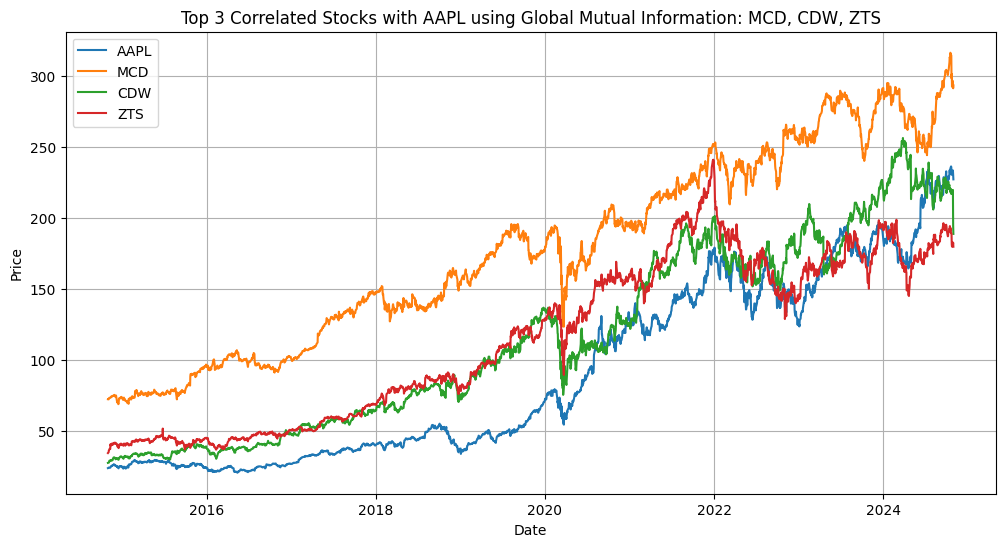

In [7]:
plot_most_correlated_stocks('AAPL', 'mi', 'global_corr')

## Global Pearson Struggles with Nonlinearity in the Market

<Figure size 640x480 with 0 Axes>

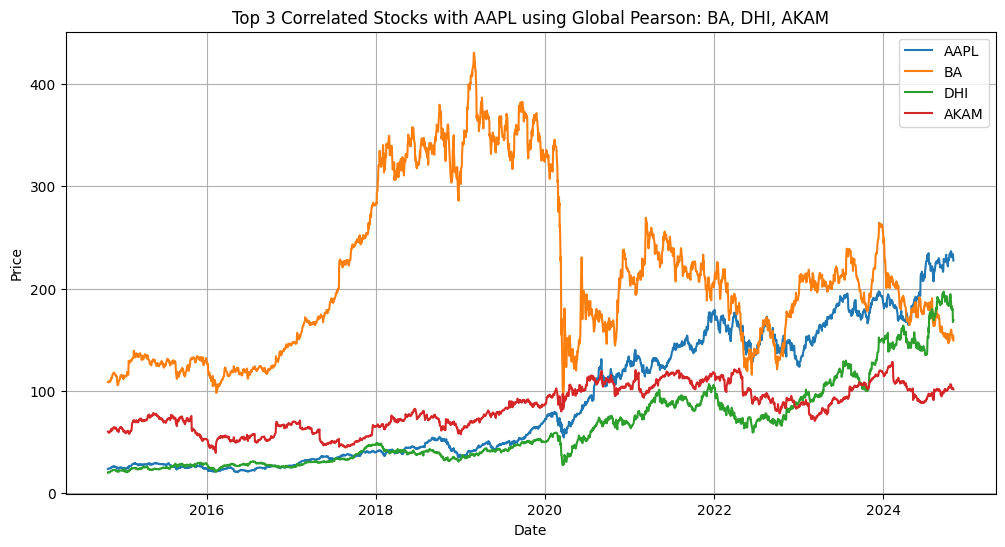

In [8]:
plot_most_correlated_stocks('AAPL', 'pcc', 'global_corr')

## Mutual Information and Pearson Perform Similarly Well on a Local Scope (the Length of 1 Fiscal Quarter)

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

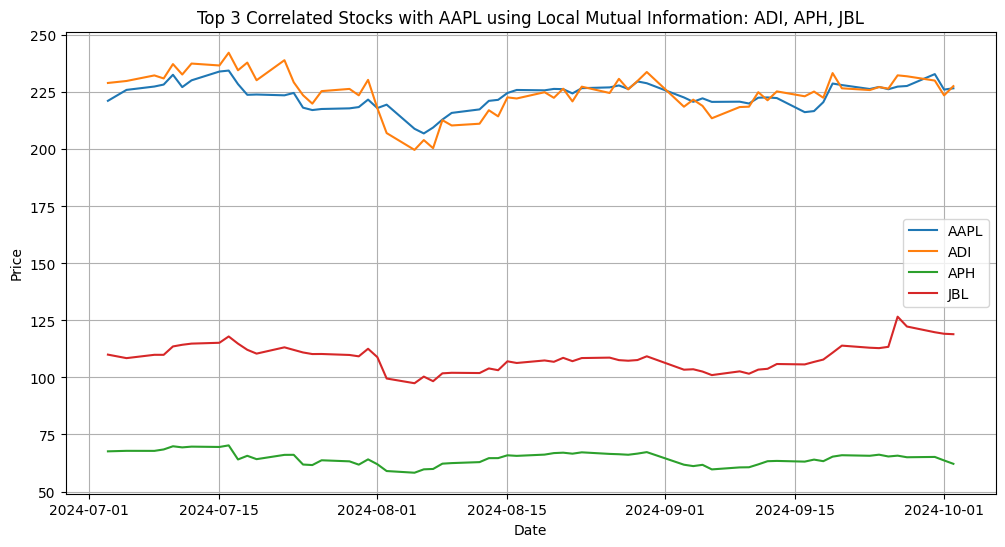

In [9]:
plot_most_correlated_stocks('AAPL', 'mi', 'local_corr_38')

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

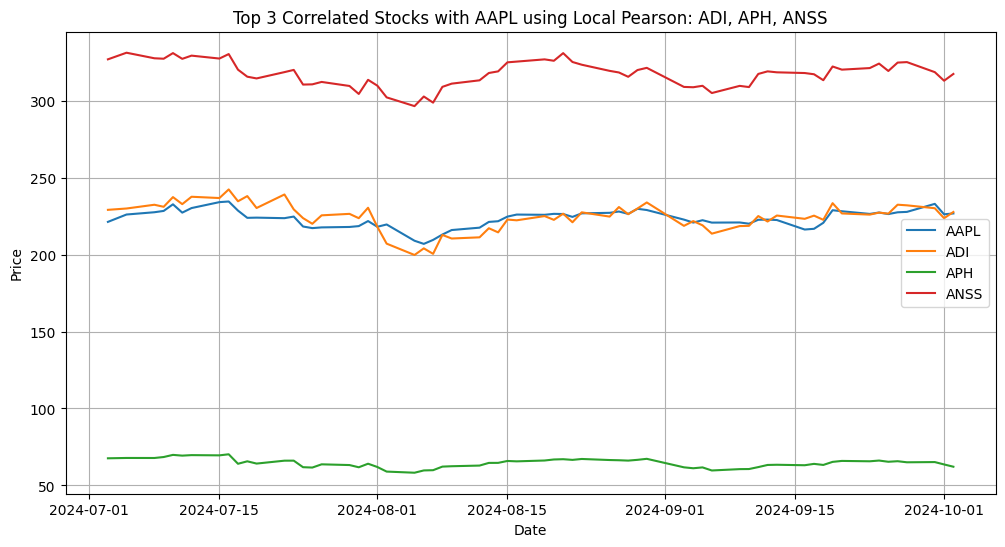

In [10]:
plot_most_correlated_stocks('AAPL', 'pcc', 'local_corr_38')

## Construct Temporal PyG Dataset

In [11]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html

from typing import Sequence, Union
import numpy as np

Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [12]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [13]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Dataset loader for SP500 stock prices
class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope):
        self._read_csv(corr_name, corr_scope)

    # Load a global correlation under the name corr_name
    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{workdir}/{corr_name}/global_corr.csv', delimiter=',')

    # Load a local correlation under the name corr_name
    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{workdir}/{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    # Helper function for reading a correlation with type corr_name and scope corr_scope from CSV file
    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                # Stack global and local correlation matrices for dual correlation
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]

        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi

        df = pd.read_csv(f'{workdir}/sp500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]

        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        # Construct a fully-connected graph
        def helper(corr_index):
            return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        # Edge weights are the correlations between stocks
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            # Flatten the first two dimensions
            return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        # Given previous batch_size stock prices...
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        # Returning the data iterator where the train is designed for many-to-many predictions (each day predict next day's price)
        # while the validation and test are many-to-one predictions (many past days predict tomorrow's price)

        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        # We do a 8-1-1 split for train-validation-test. Since the test set is one year apart from training,
        # It is much more challenging to predict.
        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [14]:
# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [15]:
# Adapted from reference implementation of Differential Transformer, included an optional A input to MultiheadDiffAttn.forward()
# https://github.com/microsoft/unilm/blob/master/Diff-Transformer/multihead_diffattn.py

import math
import torch
import torch.nn.functional as F
from torch import nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


# Differential Graph Attention with multiple heads
class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads

        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)

    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        # Project input x into query, key, and value
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling

        # Compute attention weights by multiplying query and key
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        # Apply attention mask
        if attn_mask is not None:
            attn_weights += attn_mask
        # Calculate attention scores using softmax
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        # Calculate the lambda used for differential attention
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        # Optionally condition the differential attention on a graph prior A
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]

        # Compute output embeddings by mixing values based on their attention scores
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        return (attn, attn_weights)


In [16]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

# A normal feedforward layer
class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

# Wrapper code for MultiheadDiffAttn with layer norm and feedforward after the attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x

# Differential Graph Transformer = temporal attention + spatial attention
# Spatial attention may optionally receive an adjacency matrix for conditioning.
class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, num_layers=2, expand_ratio=1, dropout=0.1, T=128, N=472, use_spatial=True):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.use_spatial = use_spatial
        if use_spatial:
            self.spatial_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
        self.temporal_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])

    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == 1)
        assert(T <= self.T and N == self.N)

        # Compute initial node embedding for the graph transformer
        # Node embedding incorporates current stock prices, stock embeddings, and time embeddings.
        x = x.permute(1, 0, 2) # T, N, D
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.permute(1, 0, 2) # T, N, D

        x = x.permute(1, 0, 2) # N, T, D

        # Iterate through each layer of DGT
        for i in range(self.num_layers):
            # First apply temporal attention to learn temporal dependencies
            temporal_causal_mask = torch.triu(
                torch.zeros([T, T])
                    .float()
                    .fill_(float("-inf")),
                    1,
                ).expand(N, self.num_heads*2, T, T).to(x.device)
            x = self.temporal_attns[i](x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

            # Next apply spatial attention (aka differential graph attention) to learn interstock relations
            if self.use_spatial:
                x = x.permute(1, 0, 2) # T, N, D
                A = to_dense_adj(edge_index, edge_attr=edge_weight)
                # Encountered more than one adjacency matrices, e.g. dual correlations
                if len(A.size()) == 4:
                    A = A.reshape(A.size(-1), A.size(1), A.size(2))
                x = self.spatial_attns[i](x, A, need_weights=need_weights) + x
                x = x.permute(1, 0, 2) # N, T, D

        return x

# GRU Baseline

In [17]:
# Gated Recurrent Unit baseline for comparison
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        x: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(x)
        return outputs

# Driver

In [18]:
import torch
import torch.nn.functional as F

# Common drive for all models
class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.corr_name = corr_name
        self.corr_scope = corr_scope

    # Run on the provided graph (specified with edge_index and edge_weight) and temporal signal x (past stock prices)
    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        # Use final linear layer for regression
        return self.linear(F.relu(outputs)), outputs

    # Get the model name for display and saving model weights
    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU':
            return f'{arch}'
        elif arch == 'DGT':
            name = f'{arch}{"" if self.recurrent.use_spatial else "_no_spatial"}'
            if self.corr_scope is not None:
                name += f'_{self.corr_name}_{self.corr_scope}'
            return name

    # Get the model architecture for display
    def model_arch(self):
        return self.recurrent.__class__.__name__

    # Set the device for the model
    def model_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Evaluation on Price Regression with RMSE and MAE

In [19]:
import math

# Root Mean Squared Error for evaluation
def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

# Mean Absolute Error for evaluation
def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [20]:
import wandb

# Helper function for inference
def infer(model, snapshot):
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]

# Evaluate the model on eval_dataset and calculate RMSE and MAE
def eval(model, eval_dataset):
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats = torch.stack(y_hats, dim=0).squeeze().to(model.model_device())
        ys = torch.stack(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        return {'y_hats': y_hats, 'ys': ys, 'rmse': eval_rmse, 'mae': eval_mae}

In [21]:
# Helper function to get a model based on the input configs, optionally loads the weight if load_weights=True
def get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False):
    node_features = 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2, use_spatial=use_spatial)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=2)
    if load_weights:
        model.load_state_dict(torch.load(f'{workdir}/models/{model.model_name()}_lr_{lr}.pth', weights_only=True))
    return model.to(model.model_device())


# Training

**Note: Training took 3 hours on a T4. You can skip the following code block and run the evaluations directly as our checkpoints are already downloaded.** In case you are training, you can also set `track_with_wandb` to `False` if you don't want to track with Weights and Biases.

In [22]:
import wandb
import os

# Train a model with the input configs on train_samples for num_epochs under the learning rate lr
# You can pass track_with_wandb=True to trace the entire training process with Weights and Biases
def train(gnn, use_spatial, corr_name, corr_scope, train_samples, val_samples, num_epochs, lr, track_with_wandb):
    os.makedirs(f'{workdir}/models', exist_ok=True)

    model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_rmse = float('inf')
    best_val_mae = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb_run = wandb.init(project="cs224w-stock-market-prediction",
                   name=f'{model.model_name()}_lr_{lr}',
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                       "use_spatial": use_spatial,
                   },
                   reinit=True,
                   )

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            optimizer.zero_grad()
            X = snapshot.x
            y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            loss = F.mse_loss(y_hats.squeeze(), snapshot.y.to(model.model_device()))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if track_with_wandb:
                wandb.log({"epoch": epoch, "step": step, "train/loss": loss.item() })
        train_loss /= len(train_samples)

        if epoch % eval_per_epoch == 0 or epoch == num_epochs - 1:
            result = eval(model, val_samples)
            val_rmse = result['rmse']
            val_mae = result['mae']
            print(f'{model.model_name()} epoch {epoch} val/rmse: {val_rmse} val/mae: {val_mae}')
            if track_with_wandb:
                wandb.log({"epoch": epoch, "val/rmse": val_rmse, "val/mae": val_mae })
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_mae = val_mae
                torch.save(model.state_dict(), f'{workdir}/models/{model.model_name()}_lr_{lr}.pth')
    if track_with_wandb:
        wandb.log({"val/best_rmse": best_val_rmse, "val/best_mae": best_val_mae })
        return wandb_run


def run(args):
    config, num_epochs, track_with_wandb = args
    gnn, use_spatial, corr_name, corr_scope = config
    dataset = get_dataset(corr_name, corr_scope)
    # Do a grid search over learning rate. We found that models are sensitive to lr so we need to try different options.
    for lr in [0.01, 0.1]:
        wandb_run = train(gnn, use_spatial, corr_name, corr_scope, dataset['train_samples'], dataset['val_samples'], num_epochs, lr, track_with_wandb)
        # Test
        best_model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=True)
        result = eval(best_model, dataset['test_samples'])
        test_rmse = result['rmse']
        test_mae = result['mae']
        print(f'{best_model.model_name()} lr: {lr} test/rmse: {test_rmse} test/mae: {test_mae}')
        if track_with_wandb:
            wandb.log({"test/rmse": test_rmse, "test/mae": test_mae })
            wandb_run.finish()

# List all the model variants for the experiment
model_configs = [(GRU, False, None, None),
                 (DGT, False, None, None),
                 (DGT, True, None, None),
                 (DGT, True, 'mi', 'global'),
                 (DGT, True, 'mi', 'local'),
                 (DGT, True, 'mi', 'dual'),
                 (DGT, True, 'pcc', 'global'),
                 (DGT, True, 'pcc', 'local'),
                 (DGT, True, 'pcc', 'dual'),
                 ]

num_epochs = 100
track_with_wandb = True

if track_with_wandb:
    wandb.login()

_ = list(map(run, [(config, num_epochs, track_with_wandb) for config in model_configs]))

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: k-boroz (opencampus_kiko). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


GRU epoch 0 val/rmse: 1.0151258562542624 val/mae: 0.5934833884239197
GRU epoch 10 val/rmse: 0.7394664072011641 val/mae: 0.24550306797027588
GRU epoch 20 val/rmse: 0.7674437349427956 val/mae: 0.2417578399181366
GRU epoch 30 val/rmse: 0.6855584602789891 val/mae: 0.13805679976940155
GRU epoch 40 val/rmse: 0.6683109812157823 val/mae: 0.1362270712852478
GRU epoch 50 val/rmse: 0.6567212184121727 val/mae: 0.12936756014823914
GRU epoch 60 val/rmse: 0.6512660415562784 val/mae: 0.1538236290216446
GRU epoch 70 val/rmse: 0.6393448902919666 val/mae: 0.1312980055809021
GRU epoch 80 val/rmse: 0.6378874321394541 val/mae: 0.14947465062141418
GRU epoch 90 val/rmse: 0.6279125062956136 val/mae: 0.13595153391361237
GRU epoch 99 val/rmse: 0.6195823465564757 val/mae: 0.11029697954654694
GRU lr: 0.01 test/rmse: 3.1166079945745024 test/mae: 0.4076187312602997


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
step,▆▃▃▆▇▄▆▇█▅▄▃▆▂▂▂▃▆▄▄▇▆▁▅▇▃▄▆▆▁▃▆▅▂▆▅▂█▇▆
test/mae,▁
test/rmse,▁
train/loss,▅█▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▃▃▁▁▁▂▁▂▁▁
val/rmse,█▃▄▂▂▂▂▁▁▁▁
epoch,99
step,14


GRU epoch 0 val/rmse: 1.147122415157888 val/mae: 0.7995038032531738
GRU epoch 10 val/rmse: 1.0865229942462133 val/mae: 0.5747919082641602
GRU epoch 20 val/rmse: 1.1592675603968394 val/mae: 0.7387993931770325
GRU epoch 30 val/rmse: 1.1101862130896667 val/mae: 0.624571681022644
GRU epoch 40 val/rmse: 1.0454624382105593 val/mae: 0.5586006045341492
GRU epoch 50 val/rmse: 0.9844211083164526 val/mae: 0.4778263568878174
GRU epoch 60 val/rmse: 1.0663733844094228 val/mae: 0.5754823684692383
GRU epoch 70 val/rmse: 1.0399111386996494 val/mae: 0.5042101740837097
GRU epoch 80 val/rmse: 1.014945169480599 val/mae: 0.48927828669548035
GRU epoch 90 val/rmse: 1.0538482717935054 val/mae: 0.5330270528793335
GRU epoch 99 val/rmse: 0.969964189409132 val/mae: 0.4710395634174347
GRU lr: 0.1 test/rmse: 3.527882413405376 test/mae: 1.0555206537246704


epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
step,▁▄▂▂▇▅▇▇█▂▇▅▄▆█▄▅▁▁▁▂▁▆▇▁▃▆▂▂▆▃▄▅▃▇▆▆▆▄▄
test/mae,▁
test/rmse,▁
train/loss,█▂▄▄▂▂▃▂▄▄▃▁▃▁▂▄▂▂▁▁▁▃▁▂▁▂▁▁▂▂▁▁▂▁▁▁▂▁▂▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▃▇▄▃▁▃▂▁▂▁
val/rmse,█▅█▆▄▂▅▄▃▄▁
epoch,99
step,14


DGT_no_spatial epoch 0 val/rmse: 1.0516432732541026 val/mae: 0.6799300909042358
DGT_no_spatial epoch 10 val/rmse: 0.5059577816720363 val/mae: 0.17544981837272644
DGT_no_spatial epoch 20 val/rmse: 0.4525906931368216 val/mae: 0.1393440067768097
DGT_no_spatial epoch 30 val/rmse: 0.4252298266622955 val/mae: 0.12889644503593445
DGT_no_spatial epoch 40 val/rmse: 0.400435394017216 val/mae: 0.118231400847435
DGT_no_spatial epoch 50 val/rmse: 0.36498747859667224 val/mae: 0.09809175878763199
DGT_no_spatial epoch 60 val/rmse: 0.3594312209229434 val/mae: 0.10356435179710388
DGT_no_spatial epoch 70 val/rmse: 0.3336577240219205 val/mae: 0.11112850904464722
DGT_no_spatial epoch 80 val/rmse: 0.32225048145201995 val/mae: 0.08382288366556168
DGT_no_spatial epoch 90 val/rmse: 0.31846378229186056 val/mae: 0.08361205458641052
DGT_no_spatial epoch 99 val/rmse: 0.3056713383695309 val/mae: 0.07731342315673828
DGT_no_spatial lr: 0.01 test/rmse: 1.4920656643804655 test/mae: 0.1991715133190155


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
step,▁█▅▃▆▅▇▃▄▇▃▇▅▅▇▁▅▅▅█▆▁▃▃▅▅▇▇▅██▂▄▃▃▃▃▂▇▇
test/mae,▁
test/rmse,▁
train/loss,█▃▃▃▃▂▂▂▃▂▁▁▁▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▂▂▂▁▁▁▁▁▁▁
val/rmse,█▃▂▂▂▂▂▁▁▁▁
epoch,99
step,14


DGT_no_spatial epoch 0 val/rmse: 0.7455923182958474 val/mae: 0.5306437015533447
DGT_no_spatial epoch 10 val/rmse: 0.2376273673249165 val/mae: 0.1642322540283203
DGT_no_spatial epoch 20 val/rmse: 0.2251414837651074 val/mae: 0.15359073877334595
DGT_no_spatial epoch 30 val/rmse: 0.2587245212901415 val/mae: 0.1711944043636322
DGT_no_spatial epoch 40 val/rmse: 0.26055001023906893 val/mae: 0.17343495786190033
DGT_no_spatial epoch 50 val/rmse: 0.2182623673329115 val/mae: 0.13900776207447052
DGT_no_spatial epoch 60 val/rmse: 0.17033703281725954 val/mae: 0.09737835824489594
DGT_no_spatial epoch 70 val/rmse: 0.21870207261523666 val/mae: 0.1400461047887802
DGT_no_spatial epoch 80 val/rmse: 0.23271536528880676 val/mae: 0.1374342441558838
DGT_no_spatial epoch 90 val/rmse: 0.2509344043279461 val/mae: 0.1355830729007721
DGT_no_spatial epoch 99 val/rmse: 0.19533162976995996 val/mae: 0.12171226739883423
DGT_no_spatial lr: 0.1 test/rmse: 0.4328992281618065 test/mae: 0.18165773153305054


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
step,▃▆▆▃▂▁▁▆▃▂▅▅█▇▄▃▇▃▁▅▇▂▇▂▃▅▃▃▇▅▅▃▇▂▇▁▇▁▆▅
test/mae,▁
test/rmse,▁
train/loss,█▆▃▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▂▂▂▂▂▁▂▂▂▁
val/rmse,█▂▂▂▂▂▁▂▂▂▁
epoch,99
step,14


DGT epoch 0 val/rmse: 1.1663328215372715 val/mae: 0.866641104221344
DGT epoch 10 val/rmse: 0.5661705842233048 val/mae: 0.18316423892974854
DGT epoch 20 val/rmse: 0.4797872657038466 val/mae: 0.141910582780838
DGT epoch 30 val/rmse: 0.46390838440108234 val/mae: 0.15902476012706757
DGT epoch 40 val/rmse: 0.4005524843141996 val/mae: 0.12455122172832489
DGT epoch 50 val/rmse: 0.40952463109017445 val/mae: 0.10992292314767838
DGT epoch 60 val/rmse: 0.42137112373146624 val/mae: 0.13949576020240784
DGT epoch 70 val/rmse: 0.38506452694684307 val/mae: 0.21908588707447052
DGT epoch 80 val/rmse: 0.3309199979114579 val/mae: 0.11764570325613022
DGT epoch 90 val/rmse: 0.33019609995222 val/mae: 0.11783812195062637
DGT epoch 99 val/rmse: 0.3275464839014915 val/mae: 0.11910999566316605
DGT lr: 0.01 test/rmse: 1.473704888039203 test/mae: 0.2925158739089966


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
step,▃▃▃▃▁▃▅▁▃▃▄▅▅▇█▄▇▁█▂▇▁▂▁▁█▃▁▄▃▂▄▁▇▁▃▃▇▁▅
test/mae,▁
test/rmse,▁
train/loss,█▃▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▂▁▁▁▁▁▂▁▁▁
val/rmse,█▃▂▂▂▂▂▁▁▁▁
epoch,99
step,14


DGT epoch 0 val/rmse: 1.2528722189421675 val/mae: 1.1105965375900269
DGT epoch 10 val/rmse: 0.6066736844813188 val/mae: 0.146450012922287
DGT epoch 20 val/rmse: 0.6511204379429594 val/mae: 0.33825546503067017
DGT epoch 30 val/rmse: 0.544522374873031 val/mae: 0.2150142341852188
DGT epoch 40 val/rmse: 0.6574977185024812 val/mae: 0.3009336590766907
DGT epoch 50 val/rmse: 0.4153857768839304 val/mae: 0.1313445270061493
DGT epoch 60 val/rmse: 0.36706583564109163 val/mae: 0.13257576525211334
DGT epoch 70 val/rmse: 0.33499947151099696 val/mae: 0.1202550008893013
DGT epoch 80 val/rmse: 0.3908646420679214 val/mae: 0.1295650452375412
DGT epoch 90 val/rmse: 0.37920721626738946 val/mae: 0.18798206746578217
DGT epoch 99 val/rmse: 0.41624913355877485 val/mae: 0.2747070789337158
DGT lr: 0.1 test/rmse: 1.628739163178983 test/mae: 0.23096409440040588


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
step,▇▅▃▃▅▇▃▅▂▁▃▅▇▅▃▃▅▆▇▂▇▂▅▇▃█▁▇▅▇▅▂▃▅█▅▃█▂█
test/mae,▁
test/rmse,▁
train/loss,▃▆▂▁▁▂█▃▂▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val/best_mae,▁
val/best_rmse,▁
val/mae,█▁▃▂▂▁▁▁▁▁▂
val/rmse,█▃▃▃▃▂▁▁▁▁▂
epoch,99
step,14


DGT_mi_global epoch 0 val/rmse: 1.0012687740399335 val/mae: 0.6714795827865601
DGT_mi_global epoch 10 val/rmse: 0.5359844843341077 val/mae: 0.31612247228622437
DGT_mi_global epoch 20 val/rmse: 0.502615406391655 val/mae: 0.2863154113292694
DGT_mi_global epoch 30 val/rmse: 0.3854373161695279 val/mae: 0.23913811147212982
DGT_mi_global epoch 40 val/rmse: 0.19174504949229512 val/mae: 0.11173715442419052
DGT_mi_global epoch 50 val/rmse: 0.19272254341589656 val/mae: 0.12769179046154022
DGT_mi_global epoch 60 val/rmse: 0.17119214568601335 val/mae: 0.1005631685256958
DGT_mi_global epoch 70 val/rmse: 0.15980018018186004 val/mae: 0.10093577951192856
DGT_mi_global epoch 80 val/rmse: 0.14929510504782809 val/mae: 0.08889802545309067
DGT_mi_global epoch 90 val/rmse: 0.14006206637412835 val/mae: 0.08726727962493896
DGT_mi_global epoch 99 val/rmse: 0.19063454393040083 val/mae: 0.11815609037876129
DGT_mi_global lr: 0.01 test/rmse: 0.46510339746130386 test/mae: 0.11491794139146805


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇█████
step,▇▃▆▅█▃▃▇▃▅▁▂▄▇▃█▄█▃▆▇▃▁▃▁▅▁▇▇▁▄▃▅▃▂▇█▂█▃
test/mae,▁
test/rmse,▁
train/loss,▇▂▂▁▁▂▁▂▂▃▂▁▂▂▇▂█▁▁▂▂▂▅▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▄▃▃▁▁▁▁▁▁▁
val/rmse,█▄▄▃▁▁▁▁▁▁▁
epoch,99
step,14


DGT_mi_global epoch 0 val/rmse: 0.8252649402022962 val/mae: 0.6091215014457703
DGT_mi_global epoch 10 val/rmse: 0.628280778802649 val/mae: 0.20826566219329834
DGT_mi_global epoch 20 val/rmse: 0.4549073647948406 val/mae: 0.13138806819915771
DGT_mi_global epoch 30 val/rmse: 0.43879581035654247 val/mae: 0.20296455919742584
DGT_mi_global epoch 40 val/rmse: 0.3909421777483479 val/mae: 0.0946093201637268
DGT_mi_global epoch 50 val/rmse: 0.37161972516393743 val/mae: 0.10006465017795563
DGT_mi_global epoch 60 val/rmse: 0.5672059300478544 val/mae: 0.4679655432701111
DGT_mi_global epoch 70 val/rmse: 0.6988751083794231 val/mae: 0.4168681204319
DGT_mi_global epoch 80 val/rmse: 0.6391157421886711 val/mae: 0.21604809165000916
DGT_mi_global epoch 90 val/rmse: 0.6124751874218606 val/mae: 0.2516571283340454
DGT_mi_global epoch 99 val/rmse: 0.8388722322998409 val/mae: 0.17682863771915436
DGT_mi_global lr: 0.1 test/rmse: 1.6498760436920556 test/mae: 0.1788974553346634


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██████
step,▅▅▅▂▁▇▃▃▂▄▄▅▃▄▅▇▃▇▂▃▅▇▇▁▅▃▄▃▃█▅▇▇▂▃▂▅▁▃▃
test/mae,▁
test/rmse,▁
train/loss,▂▂▂▁▂▁▁▂▁▂▁▁▁▁▂▂▄▄▂▁▁▁▁▁▁▃▂▂█▅▃▄▅▁▁▁▂▂▂▂
val/best_mae,▁
val/best_rmse,▁
val/mae,█▃▂▂▁▁▆▅▃▃▂
val/rmse,█▅▂▂▁▁▄▆▅▅█
epoch,99
step,14


DGT_mi_local epoch 0 val/rmse: 0.9002928111801067 val/mae: 0.5393624305725098
DGT_mi_local epoch 10 val/rmse: 0.6887280160542051 val/mae: 0.4005378186702728
DGT_mi_local epoch 20 val/rmse: 0.4494036915762458 val/mae: 0.2704002857208252
DGT_mi_local epoch 30 val/rmse: 0.2686673014951199 val/mae: 0.14062510430812836
DGT_mi_local epoch 40 val/rmse: 0.2844522879445983 val/mae: 0.20511041581630707
DGT_mi_local epoch 50 val/rmse: 0.16961481588168448 val/mae: 0.11053712666034698
DGT_mi_local epoch 60 val/rmse: 0.17120601223983523 val/mae: 0.10645116120576859
DGT_mi_local epoch 70 val/rmse: 0.18160796128140974 val/mae: 0.1133645623922348
DGT_mi_local epoch 80 val/rmse: 0.1421013135967102 val/mae: 0.09032121300697327
DGT_mi_local epoch 90 val/rmse: 0.15679185611236277 val/mae: 0.09798093140125275
DGT_mi_local epoch 99 val/rmse: 0.14165065177569927 val/mae: 0.10277072340250015
DGT_mi_local lr: 0.01 test/rmse: 0.3241913680497987 test/mae: 0.13397999107837677


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
step,▅▆█▇▃▃▇▂▅▄▅▃▃▇▆▅▆▇▇▃▄▇▇▃▄▇▃▃▇▁▁▇▁▇█▁▁▇▂▇
test/mae,▁
test/rmse,▁
train/loss,▄▄▁▁▁▂▂▁▂▂▂█▄▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▆▄▂▃▁▁▁▁▁▁
val/rmse,█▆▄▂▂▁▁▁▁▁▁
epoch,99
step,14


DGT_mi_local epoch 0 val/rmse: 1.037091673504184 val/mae: 0.5196841359138489
DGT_mi_local epoch 10 val/rmse: 1.060045773759421 val/mae: 0.7239880561828613
DGT_mi_local epoch 20 val/rmse: 0.9378771341252035 val/mae: 0.2847558259963989
DGT_mi_local epoch 30 val/rmse: 0.7247933619443653 val/mae: 0.2686854898929596
DGT_mi_local epoch 40 val/rmse: 1.01728409456467 val/mae: 0.28426408767700195
DGT_mi_local epoch 50 val/rmse: 0.9637774857635276 val/mae: 0.25843414664268494
DGT_mi_local epoch 60 val/rmse: 0.7276040272222197 val/mae: 0.1767144352197647
DGT_mi_local epoch 70 val/rmse: 1.1755456022944113 val/mae: 0.3743884861469269
DGT_mi_local epoch 80 val/rmse: 1.273515897806638 val/mae: 0.3659111261367798
DGT_mi_local epoch 90 val/rmse: 0.8872466343557628 val/mae: 0.31716471910476685
DGT_mi_local epoch 99 val/rmse: 1.2860957830452633 val/mae: 0.24827918410301208
DGT_mi_local lr: 0.1 test/rmse: 3.4772281995201415 test/mae: 0.6231410503387451


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
step,▇▇▃▅▅▂▃▆█▅█▁▃▇▇▅▅▃▅▅▁▃▁▇▁▇▃▁▁▃▃▅▇▁▂▃▃▅█▇
test/mae,▁
test/rmse,▁
train/loss,█▆▃▃▄▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▆▁▃▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,▅█▂▂▂▂▁▄▃▃▂
val/rmse,▅▅▄▁▅▄▁▇█▃█
epoch,99
step,14


DGT_mi_dual epoch 0 val/rmse: 0.7391773013740808 val/mae: 0.45560505986213684
DGT_mi_dual epoch 10 val/rmse: 0.5032932189825671 val/mae: 0.3045569658279419
DGT_mi_dual epoch 20 val/rmse: 0.39251623092792287 val/mae: 0.2444455772638321
DGT_mi_dual epoch 30 val/rmse: 0.37159131473368523 val/mae: 0.22902081906795502
DGT_mi_dual epoch 40 val/rmse: 0.2654297756394218 val/mae: 0.16484399139881134
DGT_mi_dual epoch 50 val/rmse: 0.25267701065461456 val/mae: 0.15037177503108978
DGT_mi_dual epoch 60 val/rmse: 0.2815375579938595 val/mae: 0.17735306918621063
DGT_mi_dual epoch 70 val/rmse: 0.1762174650948065 val/mae: 0.11425253003835678
DGT_mi_dual epoch 80 val/rmse: 0.16801417091504559 val/mae: 0.1077650710940361
DGT_mi_dual epoch 90 val/rmse: 0.20235126105842394 val/mae: 0.168687105178833
DGT_mi_dual epoch 99 val/rmse: 0.1216295180214235 val/mae: 0.0851675346493721
DGT_mi_dual lr: 0.01 test/rmse: 0.2598891143975098 test/mae: 0.09928729385137558


epoch,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
step,▃█▂▆▇▅▇▃▇▆▄▅▆▇▁▁▇▁▅▃▄▃▃█▇▅▃▃▂▄▂▅▅▅▄▃▄▅▅▇
test/mae,▁
test/rmse,▁
train/loss,█▃▃▄▆▅▂▇▃▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▂▁▁▁▁▂▁▂▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▅▄▄▃▂▃▂▁▃▁
val/rmse,█▅▄▄▃▂▃▂▂▂▁
epoch,99
step,14


DGT_mi_dual epoch 0 val/rmse: 0.6942267996085015 val/mae: 0.43968915939331055
DGT_mi_dual epoch 10 val/rmse: 1.513055097374729 val/mae: 1.2570449113845825
DGT_mi_dual epoch 20 val/rmse: 0.21284556130644008 val/mae: 0.12287840992212296
DGT_mi_dual epoch 30 val/rmse: 0.29924503240868056 val/mae: 0.218398317694664
DGT_mi_dual epoch 40 val/rmse: 0.25668211417240455 val/mae: 0.18500438332557678
DGT_mi_dual epoch 50 val/rmse: 0.31338376011452096 val/mae: 0.2572592794895172
DGT_mi_dual epoch 60 val/rmse: 0.29370700643298053 val/mae: 0.24092897772789001
DGT_mi_dual epoch 70 val/rmse: 0.2481150796189882 val/mae: 0.1967838853597641
DGT_mi_dual epoch 80 val/rmse: 0.24141548534122279 val/mae: 0.17510837316513062
DGT_mi_dual epoch 90 val/rmse: 0.2549060211723098 val/mae: 0.1469665765762329
DGT_mi_dual epoch 99 val/rmse: 0.18624654659487494 val/mae: 0.13340604305267334
DGT_mi_dual lr: 0.1 test/rmse: 0.6633853826118248 test/mae: 0.21146634221076965


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇███
step,█▃█▃▃▅█▂▇▁▄▃▅▅▇█▅▃▅▅▃▁▂▇▅▆▃▂▇▃▆▃▅▆▃▆▂▇▂▇
test/mae,▁
test/rmse,▁
train/loss,▃▂▂▂▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,▃█▁▂▁▂▂▁▁▁▁
val/rmse,▄█▁▂▁▂▂▁▁▁▁
epoch,99
step,14


DGT_pcc_global epoch 0 val/rmse: 1.066074697074617 val/mae: 0.777685821056366
DGT_pcc_global epoch 10 val/rmse: 0.577958830588208 val/mae: 0.35283103585243225
DGT_pcc_global epoch 20 val/rmse: 0.3581205532869752 val/mae: 0.18000569939613342
DGT_pcc_global epoch 30 val/rmse: 0.28523552458925105 val/mae: 0.15971672534942627
DGT_pcc_global epoch 40 val/rmse: 0.19334186127848263 val/mae: 0.13116315007209778
DGT_pcc_global epoch 50 val/rmse: 0.23222657822078718 val/mae: 0.10899177938699722
DGT_pcc_global epoch 60 val/rmse: 0.23714674886052958 val/mae: 0.1874692142009735
DGT_pcc_global epoch 70 val/rmse: 0.1837740175451858 val/mae: 0.09711305797100067
DGT_pcc_global epoch 80 val/rmse: 0.18948618610215193 val/mae: 0.12731781601905823
DGT_pcc_global epoch 90 val/rmse: 0.1741502755572811 val/mae: 0.0949571430683136
DGT_pcc_global epoch 99 val/rmse: 0.27686721534635217 val/mae: 0.14365161955356598
DGT_pcc_global lr: 0.01 test/rmse: 0.6430229572051165 test/mae: 0.14795534312725067


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇███
step,▇▁▃▅▅▅▆▇▄▅▅▁▄▁▅▁▅▅▇▃▁▂▆▃▇▇▃▁▁▃▁▂▃▇▄█▅▁▅▁
test/mae,▁
test/rmse,▁
train/loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▄▂▂▁▁▂▁▁▁▁
val/rmse,█▄▂▂▁▁▁▁▁▁▂
epoch,99
step,14


DGT_pcc_global epoch 0 val/rmse: 0.8879743584397527 val/mae: 0.5402513146400452
DGT_pcc_global epoch 10 val/rmse: 1.8407399450916289 val/mae: 0.2869521677494049
DGT_pcc_global epoch 20 val/rmse: 1.6265783714084423 val/mae: 0.20345649123191833
DGT_pcc_global epoch 30 val/rmse: 1.4992064125145774 val/mae: 0.262802392244339
DGT_pcc_global epoch 40 val/rmse: 1.3776486635383223 val/mae: 0.39483073353767395
DGT_pcc_global epoch 50 val/rmse: 1.6133821100291263 val/mae: 0.1863420605659485
DGT_pcc_global epoch 60 val/rmse: 1.7617123216735893 val/mae: 0.224675253033638
DGT_pcc_global epoch 70 val/rmse: 1.9495031726475758 val/mae: 0.42596253752708435
DGT_pcc_global epoch 80 val/rmse: 1.72775696738175 val/mae: 0.18614937365055084
DGT_pcc_global epoch 90 val/rmse: 1.7126741696633032 val/mae: 0.20532815158367157
DGT_pcc_global epoch 99 val/rmse: 1.6333274211906297 val/mae: 0.270331472158432
DGT_pcc_global lr: 0.1 test/rmse: 3.1046794152118564 test/mae: 0.8780212998390198


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
step,▄▅▇▇▆▁▇▃▅▆▃▁▆█▃▂▁▅▃▅▃▆▅▄▅▃▁▅▂▃▃▅▇▃▅▇█▁▅▆
test/mae,▁
test/rmse,▁
train/loss,▂▂▁▁▂▁▂▁▂▁▂▁▂▁▂▅▁▁▃█▁▁▁▁▂▃▅▂▃▂▁▄▁▂▁▃▂▂▁▃
val/best_mae,▁
val/best_rmse,▁
val/mae,█▃▁▃▅▁▂▆▁▁▃
val/rmse,▁▇▆▅▄▆▇█▇▆▆
epoch,99
step,14


DGT_pcc_local epoch 0 val/rmse: 0.8985436418280034 val/mae: 0.550024151802063
DGT_pcc_local epoch 10 val/rmse: 0.6056835654869687 val/mae: 0.4801201820373535
DGT_pcc_local epoch 20 val/rmse: 0.3533077155504064 val/mae: 0.2916525900363922
DGT_pcc_local epoch 30 val/rmse: 0.15869354246609046 val/mae: 0.10822608321905136
DGT_pcc_local epoch 40 val/rmse: 0.1591691908856734 val/mae: 0.11498145759105682
DGT_pcc_local epoch 50 val/rmse: 0.13670301346813016 val/mae: 0.08955355733633041
DGT_pcc_local epoch 60 val/rmse: 0.15843628549956776 val/mae: 0.09703715145587921
DGT_pcc_local epoch 70 val/rmse: 0.12820453820853162 val/mae: 0.08339686691761017
DGT_pcc_local epoch 80 val/rmse: 0.24204782334404729 val/mae: 0.20554694533348083
DGT_pcc_local epoch 90 val/rmse: 0.17953268928714503 val/mae: 0.12237368524074554
DGT_pcc_local epoch 99 val/rmse: 0.11312804879247905 val/mae: 0.07187668234109879
DGT_pcc_local lr: 0.01 test/rmse: 0.2941033328303634 test/mae: 0.08675127476453781


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
step,▂▃▃▂▅▅█▃▆▂▁▇▁▅▄▇▅▁▄▅▁▂▁▃█▆▅█▇▅▄▆▁▃▅▇▁▅▇▇
test/mae,▁
test/rmse,▁
train/loss,▂▂▂▁▂▂▂█▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▇▄▂▂▁▁▁▃▂▁
val/rmse,█▅▃▁▁▁▁▁▂▂▁
epoch,99
step,14


DGT_pcc_local epoch 0 val/rmse: 0.6162145164131906 val/mae: 0.46609604358673096
DGT_pcc_local epoch 10 val/rmse: 0.7962484327387693 val/mae: 0.25552991032600403
DGT_pcc_local epoch 20 val/rmse: 0.761364233218597 val/mae: 0.2903038263320923
DGT_pcc_local epoch 30 val/rmse: 0.6128863138177298 val/mae: 0.22324974834918976
DGT_pcc_local epoch 40 val/rmse: 0.620641483729527 val/mae: 0.20450033247470856
DGT_pcc_local epoch 50 val/rmse: 0.656507418871679 val/mae: 0.1447349190711975
DGT_pcc_local epoch 60 val/rmse: 0.762964804266313 val/mae: 0.1745220124721527
DGT_pcc_local epoch 70 val/rmse: 0.7329783042621677 val/mae: 0.16009120643138885
DGT_pcc_local epoch 80 val/rmse: 0.7164827744808504 val/mae: 0.1376502513885498
DGT_pcc_local epoch 90 val/rmse: 0.7559001428615346 val/mae: 0.20387840270996094
DGT_pcc_local epoch 99 val/rmse: 0.7303876780843128 val/mae: 0.18701553344726562
DGT_pcc_local lr: 0.1 test/rmse: 2.506897376109701 test/mae: 0.5010432004928589


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
step,▁▁▅▂▁▄▅▃▁▂▁▆▁▁▇▅▃▅▆▂▇▆▇▇▃▁▅▂▃▁▇▅▂▇▁█▃▆▇▃
test/mae,▁
test/rmse,▁
train/loss,█▄▂▁▁▁▂▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▄▄▃▂▁▂▁▁▂▂
val/rmse,▁█▇▁▁▃▇▆▅▆▅
epoch,99
step,14


DGT_pcc_dual epoch 0 val/rmse: 1.0027066199069214 val/mae: 0.531448245048523
DGT_pcc_dual epoch 10 val/rmse: 0.5686480912932805 val/mae: 0.30941909551620483
DGT_pcc_dual epoch 20 val/rmse: 0.3920950693278707 val/mae: 0.14852195978164673
DGT_pcc_dual epoch 30 val/rmse: 0.42255946547839507 val/mae: 0.16893088817596436
DGT_pcc_dual epoch 40 val/rmse: 0.36900113008165863 val/mae: 0.13784931600093842
DGT_pcc_dual epoch 50 val/rmse: 0.39474134233486063 val/mae: 0.17326299846172333
DGT_pcc_dual epoch 60 val/rmse: 0.34443931390973087 val/mae: 0.1496657431125641
DGT_pcc_dual epoch 70 val/rmse: 0.4169347218709851 val/mae: 0.26017606258392334
DGT_pcc_dual epoch 80 val/rmse: 0.16448492209415183 val/mae: 0.12450996786355972
DGT_pcc_dual epoch 90 val/rmse: 0.205356155120654 val/mae: 0.12474433332681656
DGT_pcc_dual epoch 99 val/rmse: 0.1836568034230089 val/mae: 0.10215266048908234
DGT_pcc_dual lr: 0.01 test/rmse: 0.29678211515858255 test/mae: 0.15739485621452332


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
step,▇▃▄▂▆▇▁▄▅▃▁▅▁▃██▅▂▅▆▁▃▃▃▁▅▁▂▇▁▃▇▇▃▃▃▂▅▇▅
test/mae,▁
test/rmse,▁
train/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▂▂▁▁▁▁
val/best_mae,▁
val/best_rmse,▁
val/mae,█▄▂▂▂▂▂▄▁▁▁
val/rmse,█▄▃▃▃▃▃▃▁▁▁
epoch,99
step,14


DGT_pcc_dual epoch 0 val/rmse: 0.5137868252199914 val/mae: 0.3425385653972626
DGT_pcc_dual epoch 10 val/rmse: 0.6532990547679005 val/mae: 0.16436786949634552
DGT_pcc_dual epoch 20 val/rmse: 0.5517294817377448 val/mae: 0.1413598507642746
DGT_pcc_dual epoch 30 val/rmse: 0.5629765558138379 val/mae: 0.13847942650318146
DGT_pcc_dual epoch 40 val/rmse: 0.7624036790638924 val/mae: 0.2591487765312195
DGT_pcc_dual epoch 50 val/rmse: 0.7292081594014849 val/mae: 0.3468876779079437
DGT_pcc_dual epoch 60 val/rmse: 0.8175930905783602 val/mae: 0.6307493448257446
DGT_pcc_dual epoch 70 val/rmse: 0.9565153327287272 val/mae: 0.2979082763195038
DGT_pcc_dual epoch 80 val/rmse: 0.7688234433703265 val/mae: 0.20415645837783813
DGT_pcc_dual epoch 90 val/rmse: 0.6282031708086251 val/mae: 0.21568505465984344
DGT_pcc_dual epoch 99 val/rmse: 0.6459992769815988 val/mae: 0.15335515141487122
DGT_pcc_dual lr: 0.1 test/rmse: 1.0980833044153202 test/mae: 0.5658656358718872


epoch,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█
step,█▃▃▅▃▅▅▃▅▆▄▇▁▂▅▃▄▆▄▆▇▄▄▆▄▇▆▇▃▅▄█▅▆▄▁▂▇▅▆
test/mae,▁
test/rmse,▁
train/loss,▇▃▄▁▁▁▁▁▁▁▁▃▁▂▂▂▁▂▁▂▁▂█▃▂▃▅▂▁▁▁▁▂▂▂▁▁▁▁▂
val/best_mae,▁
val/best_rmse,▁
val/mae,▄▁▁▁▃▄█▃▂▂▁
val/rmse,▁▃▂▂▅▄▆█▅▃▃
epoch,99
step,14


# Results Show Local Mutual Information Performs the Best, Followed by Dual Pearson

In [23]:
# Function to test a bunch of models given by model_configs on the test set
def test(model_configs):
    results = {}
    for config in model_configs:
        (gnn, use_spatial, corr_name, corr_scope, lr) = config
        eval_dataset = get_dataset(corr_name, corr_scope)['test_samples']
        model = get_model(gnn, use_spatial, corr_name, corr_scope, lr=lr, load_weights=True)
        if model is None:
            continue
        results[config] = eval(model=model, eval_dataset=eval_dataset)
    return results

# Test each model under its best learning rate based on validation performance
model_configs = [(GRU, False, None, None, 0.01),
                 (DGT, False, None, None, 0.1),
                 (DGT, True, None, None, 0.01),
                 (DGT, True, 'mi', 'global', 0.01),
                 (DGT, True, 'mi', 'local', 0.01),
                 (DGT, True, 'mi', 'dual', 0.01),
                 (DGT, True, 'pcc', 'global', 0.01),
                 (DGT, True, 'pcc', 'local', 0.01),
                 (DGT, True, 'pcc', 'dual', 0.01),
                 ]
test_results = test(model_configs)

In [24]:
# Test the models and show a table of results
test_results_df = []
for config, result in test_results.items():
    (arch, use_spatial, corr_name, corr_scope, lr) = config
    test_results_df.append({'Architecture': arch.__name__,
                            'Use Spatial': use_spatial,
                            'Correlation': corr_name,
                            'Scope': corr_scope,
                            'RMSE': result['rmse'],
                            'MAE': result['mae']})

test_results_df = pd.DataFrame(test_results_df)
test_results_df = test_results_df.sort_values(by='RMSE', ascending=False)
print('Test results sorted in descending RMSE (Lower the better)')
display(test_results_df)

Test results sorted in descending RMSE (Lower the better)


,Architecture,Use Spatial,Correlation,Scope,RMSE,MAE
0,GRU,False,None,None,3.116608,0.407619
2,DGT,True,None,None,1.473705,0.292516
6,DGT,True,pcc,global,0.643023,0.147955
3,DGT,True,mi,global,0.465103,0.114918
1,DGT,False,None,None,0.432899,0.181658
4,DGT,True,mi,local,0.324191,0.133980
8,DGT,True,pcc,dual,0.296782,0.157395
7,DGT,True,pcc,local,0.294103,0.086751
5,DGT,True,mi,dual,0.259889,0.099287


# Visualize Results

In [25]:
df = pd.read_csv(f'{workdir}/sp500.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
stock_names = df.columns
stock_lookup = {name: i for i, name in enumerate(stock_names)}

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

# Plot regression results on test set
def plot_regression(configs, labels, fig_name, stock_name, test_results):
    stock_index = stock_lookup[stock_name]
    plt.clf()
    plt.figure(figsize=(10, 6))
    colors = [(0.650, 0.120, 0.240, 0.6),  # red
              (0.122, 0.467, 0.706, 0.6), # blue
              (1.000, 0.498, 0.055), # orange
              (0.580, 0.403, 0.741, 0.6), # purple
              ]
    plt.rc('axes', prop_cycle=cycler('color', colors))

    for config, label in zip(configs, labels):
        result = test_results[config]
        ys = torch.tensor([y[stock_index] for y in result['ys'].cpu()])
        y_hats = torch.tensor([y_hat[stock_index] for y_hat in result['y_hats'].cpu()])
        x = np.array(range(len(ys)))
        plt.plot(x, y_hats, label=label, linewidth=1)

    plt.plot(x, ys, label="Real", color='green')
    plt.legend(fontsize=14)
    plt.title(f'Predicted vs Real {stock_name} Stock Price on Test', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.savefig(fig_name)
    plt.show()


## Local Mutual Information Outperforms Global and Dual

<Figure size 640x480 with 0 Axes>

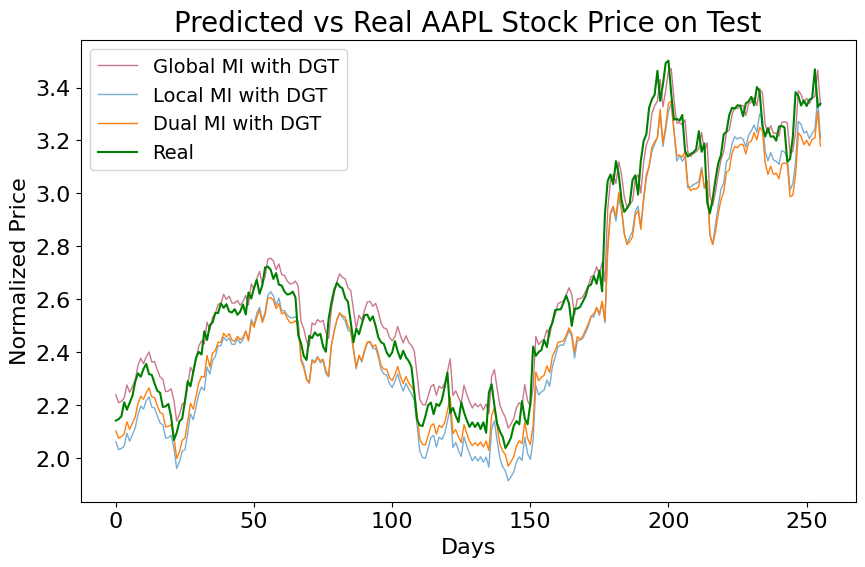

In [27]:
plot_regression([(DGT, True, 'mi', 'global', 0.01),
                (DGT, True, 'mi', 'local', 0.01),
                (DGT, True, 'mi', 'dual', 0.01)
                ],
                ['Global MI with DGT', 'Local MI with DGT', 'Dual MI with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_MI.png', test_results=test_results)

## Dual Pearson Outperforms Global and Local

<Figure size 640x480 with 0 Axes>

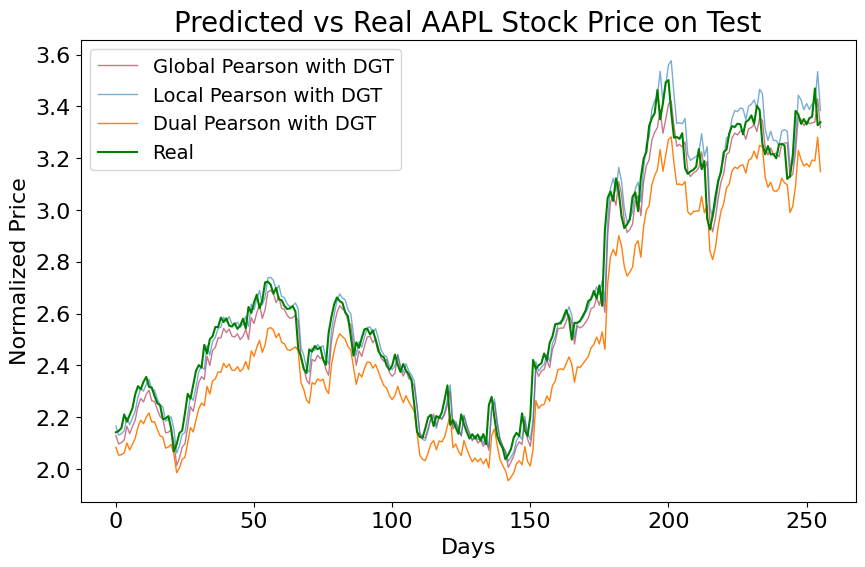

In [28]:
plot_regression([(DGT, True, 'pcc', 'global', 0.01),
                (DGT, True, 'pcc', 'local', 0.01),
                (DGT, True, 'pcc', 'dual', 0.01)],
                ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_PCC.png', test_results=test_results)